# Competition Info

http://boostcamp.stages.ai/competitions/1/data/description

마스크를 착용하는 건 COIVD-19의 확산을 방지하는데 중요한 역할을 합니다. 제공되는 이 데이터셋은 사람이 마스크를 착용하였는지 판별하는 모델을 학습할 수 있게 해줍니다. 모든 데이터셋은 아시아인 남녀로 구성되어 있고 나이는 20대부터 70대까지 다양하게 분포하고 있습니다. 간략한 통계는 다음과 같습니다.

- 전체 사람 명 수 : 4,500

- 한 사람당 사진의 개수: 7 [마스크 착용 5장, 이상하게 착용(코스크, 턱스크) 1장, 미착용 1장]

- 이미지 크기: (384, 512)

-------------

학습 데이터와 평가 데이터를 구분하기 위해 임의로 섞어서 분할하였습니다. 60%의 사람들은 학습 데이터셋으로 활용되고, 20%는 public 테스트셋, 그리고 20%는 private 테스트셋으로 사용됩니다

진행중인 대회의 리더보드 점수는 public 테스트셋으로 계산이 됩니다. 그리고 마지막 순위는 private 테스트셋을 통해 산출한 점수로 확정됩니다. private 테스트셋의 점수는 대회가 진행되는 동안 볼 수 없습니다.

- 입력값: 마스크 착용 사진, 미착용 사진, 혹은 이상하게 착용한 사진(코스크, 턱스크)

    - 예시:
        - 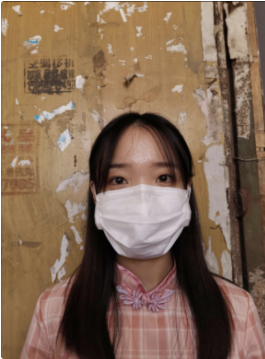


- 결과값: 총 18개의 class를 예측해야합니다. 결과값으로 0~17에 해당되는 숫자가 각 이미지 당 하나씩 나와야합니다.

    - 예시:

        - 7 (the class of cfe1268.jpg)

        - 2 (the class of 3a2662c.jpg)
        
        - ...
        
-----

Class Description:

마스크 착용여부, 성별, 나이를 기준으로 총 18개의 클래스가 있습니다.

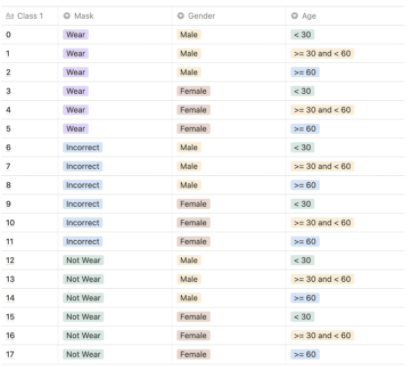



# EDA

In [1]:
%conda info


     active environment : deeplearning37
    active env location : /opt/conda/envs/deeplearning37
            shell level : 1
       user config file : /opt/ml/.condarc
 populated config files : 
          conda version : 4.9.2
    conda-build version : 3.18.11
         python version : 3.7.7.final.0
       virtual packages : __cuda=10.1=0
                          __glibc=2.27=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/conda  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/conda/pkgs
                          /opt/ml/.conda/pkgs
       envs directories : /opt/conda/envs
                          /opt/ml/.conda/envs
               platform : linux-64

In [2]:
import os
from pathlib import Path

In [3]:
BASE_DIR = Path('.').resolve().parent
BASE_DIR

PosixPath('/opt/ml')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import numpy as np
import pandas as pd

# pd.options.plotting.backend = 'plotly'

import matplotlib.image as mpimg
from PIL import Image

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [7]:
import wandb

## Load data

In [8]:
data_dir = BASE_DIR / 'input' / 'data'
test_dir = data_dir / 'eval'
train_dir = data_dir / 'train'

In [9]:
list(test_dir.iterdir())

[PosixPath('/opt/ml/input/data/eval/images'),
 PosixPath('/opt/ml/input/data/eval/info.csv'),
 PosixPath('/opt/ml/input/data/eval/._info.csv'),
 PosixPath('/opt/ml/input/data/eval/submission.csv')]

In [10]:
list(train_dir.iterdir())

[PosixPath('/opt/ml/input/data/train/images'),
 PosixPath('/opt/ml/input/data/train/._train.csv'),
 PosixPath('/opt/ml/input/data/train/train.csv'),
 PosixPath('/opt/ml/input/data/train/._images')]

### Tables

In [11]:
info_df = pd.read_csv(test_dir / "info.csv")
info_df

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,0
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,0
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,0
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,0


In [12]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageID  12600 non-null  object
 1   ans      12600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 197.0+ KB


In [13]:
info_df.ans.unique()

array([0])

In [14]:
train_df = pd.read_csv(train_dir / 'train.csv')
train_df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


In [16]:
train_df.gender.unique()

array(['female', 'male'], dtype=object)

<AxesSubplot:>

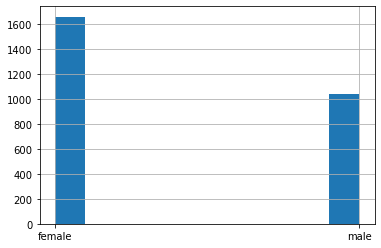

In [17]:
train_df.gender.hist()

In [18]:
train_df.race.unique()

array(['Asian'], dtype=object)

In [19]:
train_df.age.unique()

array([45, 52, 54, 58, 59, 56, 57, 55, 50, 49, 53, 51, 40, 25, 48, 29, 35,
       37, 19, 42, 24, 23, 30, 18, 22, 26, 21, 27, 60, 20, 28, 44, 34, 39,
       43, 33, 41, 47, 46, 36, 38, 32, 31])

<AxesSubplot:>

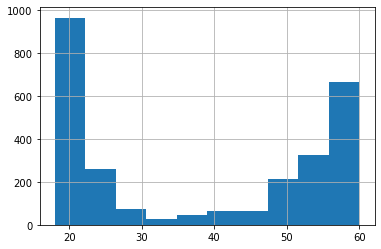

In [20]:
train_df.age.hist()

### Images

In [21]:
list((test_dir / 'images').glob('**/'))

[PosixPath('/opt/ml/input/data/eval/images')]

In [22]:
list((train_dir / 'images').glob('**/'))[:20]

[PosixPath('/opt/ml/input/data/train/images'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51'),
 PosixPath('/opt/ml/input/data/train/images/003860_male_Asian_54'),
 PosixPath('/opt/ml/input/data/train/images/001502_female_Asian_18'),
 PosixPath('/opt/ml/input/data/train/images/001514_female_Asian_22'),
 PosixPath('/opt/ml/input/data/train/images/004079_male_Asian_53'),
 PosixPath('/opt/ml/input/data/train/images/005439_female_Asian_58'),
 PosixPath('/opt/ml/input/data/train/images/001779_female_Asian_53'),
 PosixPath('/opt/ml/input/data/train/images/003602_male_Asian_58'),
 PosixPath('/opt/ml/input/data/train/images/003139_female_Asian_20'),
 PosixPath('/opt/ml/input/data/train/images/001717_male_Asian_56'),
 PosixPath('/opt/ml/input/data/train/images/005082_male_Asian_48'),
 PosixPath('/opt/ml/input/data/train/images/005500_female_Asian_49'),
 PosixPath('/opt/ml/input/data/train/images/001575_female_Asian_30'),
 PosixPath('/opt/ml/input/data/train/images/005270_ma

In [23]:
train_img_dir = train_dir / 'images'

In [24]:
sample_dir = train_img_dir / '000523_female_Asian_51'
img_l = list(sample_dir.glob('[!._]*.jpg'))
img_l += sample_dir.glob('[!._]*.jpeg')

In [25]:
img_l = sorted(img_l)

In [26]:
img_l

[PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/incorrect_mask.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask1.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask2.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask3.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask4.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask5.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/normal.jpg')]

`._` 이 오는 이미지 파일들은 뭔가? 

이미지 파일에 대한 정보를 저장하는 파일들. 실제 이미지가 아니다. 빼주자. 

https://apple.stackexchange.com/questions/14980/why-are-dot-underscore-files-created-and-how-can-i-avoid-them/14981#14981?newreg=57e1151619954b28b890801d6cb89f18

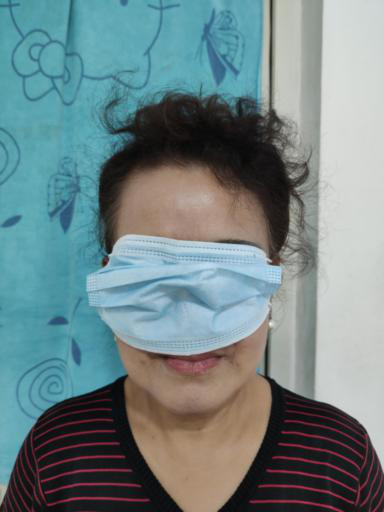

In [27]:
img = Image.open(img_l[0])
img

## Merge data DB and image DB

`train_df`의 정보와 이미지의 정보를 연결시켜주기 위해 이미지의 `path`(key)와 `filepath`, `ImageID`을 가지는 dataframe을 만들어주자. 

In [28]:
train_img_path_l = list((train_dir / 'images').glob('**/'))
train_img_path_l = train_img_path_l[1:]

In [29]:
train_img_df = []

# img_extensions_l = ['jpg', 'jpeg',]
img_extensions_l = ['jpg', 'jpeg', 'png']

for img_path in train_img_path_l:
    img_l = []
    for ext in img_extensions_l:
        img_l += img_path.glob(f'[!._]*.{ext}')
    
    for imgfile in img_l:
        row_dict = {}
        row_dict['path'] = imgfile.parts[-2]
        row_dict['filepath'] = imgfile
        row_dict['filename'] = imgfile.parts[-1]
        
        train_img_df.append(row_dict)

train_img_df = pd.DataFrame(train_img_df)
train_img_df

,path,filepath,filename
0,000523_female_Asian_51,/opt/ml/input/data/train/images/000523_female_...,mask4.jpg
1,000523_female_Asian_51,/opt/ml/input/data/train/images/000523_female_...,normal.jpg
2,000523_female_Asian_51,/opt/ml/input/data/train/images/000523_female_...,mask3.jpg
3,000523_female_Asian_51,/opt/ml/input/data/train/images/000523_female_...,mask1.jpg
4,000523_female_Asian_51,/opt/ml/input/data/train/images/000523_female_...,incorrect_mask.jpg
...,...,...,...
18895,000278_female_Asian_54,/opt/ml/input/data/train/images/000278_female_...,mask3.jpg
18896,000278_female_Asian_54,/opt/ml/input/data/train/images/000278_female_...,mask1.jpg
18897,000278_female_Asian_54,/opt/ml/input/data/train/images/000278_female_...,incorrect_mask.jpg
18898,000278_female_Asian_54,/opt/ml/input/data/train/images/000278_female_...,mask5.jpg


`train_df`와 `train_img_df`를 merge한 통합 dataframe을 만든다. 

In [48]:
df = train_df.merge(train_img_df, how='left', on='path')
df

,id,gender,race,age,path,filepath,filename
0,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask4.jpg
1,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,normal.jpg
2,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask3.jpg
3,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask1.jpg
4,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,incorrect_mask.jpg
...,...,...,...,...,...,...,...
18895,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask3.jpg
18896,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask1.jpg
18897,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,incorrect_mask.jpg
18898,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask5.jpg


(위에서 jpeg, jpg만 추릴 시) 18389개의 row이다. 

row를 보니까 갯수가 안맞는다. 2700명 * 7장 = 18900 row 있어야 한다. 

In [49]:
all_files_l = []

for img_path in train_img_path_l:
    all_files_l += img_path.iterdir()

all_files_l = [x for x in all_files_l if not x.parts[-1].startswith('._')]
all_files_l[:10]

[PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask4.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/normal.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask3.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask1.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/incorrect_mask.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask5.jpg'),
 PosixPath('/opt/ml/input/data/train/images/000523_female_Asian_51/mask2.jpg'),
 PosixPath('/opt/ml/input/data/train/images/003860_male_Asian_54/mask4.jpg'),
 PosixPath('/opt/ml/input/data/train/images/003860_male_Asian_54/normal.jpg'),
 PosixPath('/opt/ml/input/data/train/images/003860_male_Asian_54/mask3.jpg')]

In [50]:
len(all_files_l)

18900

In [51]:
all_files_ext_s = {f.parts[-1].split('.')[-1] for f in all_files_l}
all_files_ext_s

{'jpeg', 'jpg', 'png'}

PNG 파일도 있음을 알 수 있다. 

위의 `img_extensions_l`에 png도 추가해준다. 

## Data Categorization

본격적인 output category labeling을 하기 위해 데이터에 필요한 컬럼들을 만든다. 

In [52]:
def map_mask(filename):
    mask_mapper = {
        'mask1': 'mask',
        'mask2': 'mask',
        'mask3': 'mask',
        'mask4': 'mask',
        'mask5': 'mask',

        'normal': 'normal',
        'incorrect_mask': 'incorrect'
    }
    
    key = filename.split('.')[0]
    
    return mask_mapper[key]



df['mask_type'] = df.filename.map(map_mask)

In [53]:
df['age_category'] = pd.cut(df.age, [0, 30, 60, 150], labels=['young', 'middle', 'old'], right=False)

** 참고: `pd.cut()`의 범위에 주의하자. 

default로 `bins=`가 `[a, b)`가 아니고 `(a, b]`다. 

`right=False`를 해줘야 한다. 

In [54]:
df

,id,gender,race,age,path,filepath,filename,mask_type,age_category
0,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask4.jpg,mask,middle
1,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,normal.jpg,normal,middle
2,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask3.jpg,mask,middle
3,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask1.jpg,mask,middle
4,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,incorrect_mask.jpg,incorrect,middle
...,...,...,...,...,...,...,...,...,...
18895,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask3.jpg,mask,young
18896,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask1.jpg,mask,young
18897,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,incorrect_mask.jpg,incorrect,young
18898,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask5.jpg,mask,young


In [63]:
df.gender = pd.Categorical(df.gender)
df.mask_type = pd.Categorical(df.mask_type)

In [66]:
df['gender_code'] = df.gender.cat.codes
df['mask_code'] = df.mask_type.cat.codes

In [55]:
df['category'] = list(zip(df.gender, df.age_category, df.mask_type))
df.category = pd.Categorical(df.category)

In [56]:
df['cat_code'] = df.category.cat.codes

In [68]:
df = df.sort_values(by=['id', 'filepath'])

In [69]:
df

,id,gender,race,age,path,filepath,filename,mask_type,age_category,category,cat_code,gender_code,mask_code
4,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,incorrect_mask.jpg,incorrect,middle,"(female, middle, incorrect)",0,0,0
3,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask1.jpg,mask,middle,"(female, middle, mask)",1,0,1
6,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask2.jpg,mask,middle,"(female, middle, mask)",1,0,1
2,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask3.jpg,mask,middle,"(female, middle, mask)",1,0,1
0,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask4.jpg,mask,middle,"(female, middle, mask)",1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18899,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask2.jpg,mask,young,"(male, young, mask)",16,1,1
18895,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask3.jpg,mask,young,"(male, young, mask)",16,1,1
18893,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask4.jpg,mask,young,"(male, young, mask)",16,1,1
18898,006959,male,Asian,19,006959_male_Asian_19,/opt/ml/input/data/train/images/006959_male_As...,mask5.jpg,mask,young,"(male, young, mask)",16,1,1


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18900 entries, 4 to 18894
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            18900 non-null  object  
 1   gender        18900 non-null  category
 2   race          18900 non-null  object  
 3   age           18900 non-null  int64   
 4   path          18900 non-null  object  
 5   filepath      18900 non-null  object  
 6   filename      18900 non-null  object  
 7   mask_type     18900 non-null  category
 8   age_category  18900 non-null  category
 9   category      18900 non-null  category
 10  cat_code      18900 non-null  int8    
 11  gender_code   18900 non-null  int8    
 12  mask_code     18900 non-null  int8    
dtypes: category(4), int64(1), int8(3), object(5)
memory usage: 1.1+ MB


In [59]:
df[['category', 'cat_code']].drop_duplicates().sort_values(by='cat_code', ignore_index=True)

,category,cat_code
0,"(female, middle, incorrect)",0
1,"(female, middle, mask)",1
2,"(female, middle, normal)",2
3,"(female, old, incorrect)",3
4,"(female, old, mask)",4
5,"(female, old, normal)",5
6,"(female, young, incorrect)",6
7,"(female, young, mask)",7
8,"(female, young, normal)",8
9,"(male, middle, incorrect)",9


In [71]:
df[['gender', 'gender_code']].drop_duplicates().sort_values(by='gender_code', ignore_index=True)

,gender,gender_code
0,female,0
1,male,1


In [72]:
df[['mask_type', 'mask_code']].drop_duplicates().sort_values(by='mask_code', ignore_index=True)

,mask_type,mask_code
0,incorrect,0
1,mask,1
2,normal,2


<AxesSubplot:>

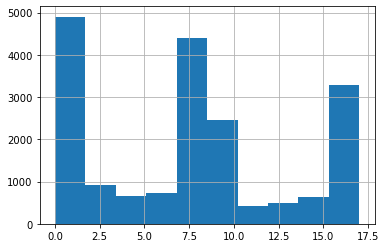

In [73]:
df.cat_code.hist()

In [74]:
df.to_pickle(BASE_DIR / 'output' / 'all_df.pkl')

## Image EDA 

In [ ]:
def img_plotter(img_l, n=7, title='Empty Title' ,param_dict=None):
    plt.figure(figsize=(20, 10))
    
    cols = 7
    rows = n // cols + 1
    
    for idx, imgfile in enumerate(img_l[:n]):
        img_arr = mpimg.imread(imgfile)
        
        plt.suptitle(title, fontsize=16)
        plt.subplot(rows, cols, idx+1)
        plt.imshow(img_arr)

In [45]:
img_l = df.filepath

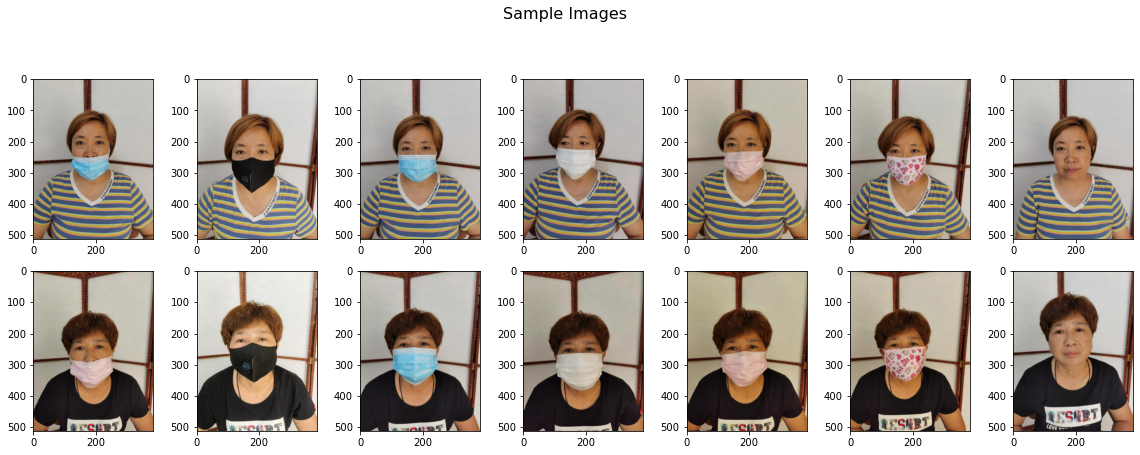

In [46]:
img_plotter(img_l, n=14, title='Sample Images')

이미지를 한 번 같은 종류끼리 겹쳐보자. 

혹시라도 얼굴의 위치가 제각각이거나 배경색이 제각각일 수 있으니까. 

아래와 같은 방법으로 이미지를 겹칠 수 있다. 

세로 방향으로 이미지를 겹쳐보도록 하자. 

In [47]:
img1, img2, *_ = img_l

img1 = mpimg.imread(img1)
img2 = mpimg.imread(img2)

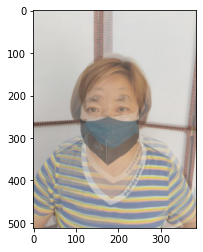

In [48]:
plt.imshow(img1, alpha=0.5)
plt.imshow(img2, alpha=0.5)

In [49]:
def img_overlay_plotter(img_l, n=7, title='Empty Title', alpha=0.3, param_dict=None):
    plt.figure(figsize=(20, 5))
    
    cols = 7
    rows = 1
    
    for idx, imgfile in enumerate(img_l[:n]):
        img_arr = mpimg.imread(imgfile)
        
        pos = idx % cols
        
        plt.suptitle(title, fontsize=16)
        plt.subplot(rows, cols, pos + 1)
        plt.imshow(img_arr, alpha=alpha)

In [50]:
len(img_l)

18900

/opt/conda/envs/deeplearning37/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


CPU times: user 47.7 s, sys: 2.54 s, total: 50.3 s
Wall time: 50.3 s


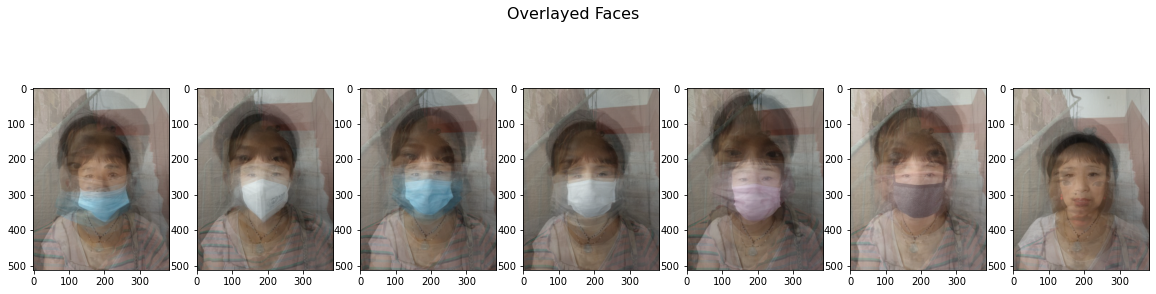

In [51]:
%%time

img_overlay_plotter(img_l, n=7000, title='Overlayed Faces')

- 배경이 서로 다르며
- 머리 크기가 아주 다르게 찍힌 사진들도 존재한다. 
- 자세히 보면 1번 incorrect에 위에서 확인했듯 눈스크를 쓴 것도 보인다. 

